# FIDE chess ratings

## Download data

### Chess ratings
The data on chess players can be downloaded directly from the [FIDE rating site](http://ratings.fide.com/download.phtml).
Download the STANDARD rating list in XML format (standard_rating_list.xml).

### Country data
Information on the world's countries with respective shapefiles can be downloaded from [Natural Earth](http://www.naturalearthdata.com/downloads/50m-cultural-vectors/) (choose "Admin 0 – Countries").

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn
#matplotlib.style.use('ggplot')

def xml2df(xml_data):
    tree = ET.parse(xml_data)
    root = tree.getroot()
    all_records = []
    headers = []
    for i, child in enumerate(root):
        record = []
        for subchild in child:
            record.append(subchild.text)
            if subchild.tag not in headers:
                headers.append(subchild.tag)
        all_records.append(record)
    return pd.DataFrame(all_records, columns=headers)

xml_data = 'data/standard_rating_list.xml'
df=xml2df(xml_data)
#Use the below code when testing, as xml2df is a bit slow:
#df.to_csv('standard_rating_list.csv', index=False)
#df=pd.read_csv('data/standard_rating_list.csv')

In [2]:
df.head()

,fideid,name,country,sex,title,w_title,o_title,foa_title,rating,games,k,birthday,flag
0,4309014,None,NZL,None,None,None,None,None,1717,0,40,None,None
1,30930898,None,USA,None,None,None,None,None,2206,24,20,None,None
2,5700230,"A B, Muhammad Yusop",MAS,M,None,None,None,None,1582,0,40,None,None
3,35077023,A Chakravarthy,IND,M,None,None,None,None,1151,0,40,1986,i
4,10207538,"A E M, Doshtagir",BAN,M,None,None,None,None,1840,0,40,1974,i



## Merge FIDE data and country data

The data obtained from Natural Earth can be converted to a csv file called "countries.csv" by *Save vector layer as..* in [QGIS](http://www.qgis.org). This can also be done using [ogr2ogr](http://www.gdal.org/ogr2ogr.html) on the command line:
``` 
ogr2ogr -f "CSV" countries.csv ne_50m_admin_0_countries.shp 
```

Some of the ISO Alpha-3 names on the dataframe must be adjusted before merging with the country data. This is necessary since the country codes in the dataframe are not found in any of the [standards](https://en.wikipedia.org/wiki/ISO_3166-1) for naming countries, and thus cannot be combined with a country shapefile. As an example, the country code for Germany must be changed from "GER" to "DEU".

In [3]:
#Correct ISO3:
df['country']=df['country'].replace({'GER': 'DEU', 'IRI': 'IRN',
'CGO': 'COD', 'TAN': 'TZA', 'LBA': 'LBY', 'MYA': 'MMR', 'VIE': 'VNM', 
'TPE': 'TWN', 'CHI': 'CHL', 'RSA': 'ZAF', 'NED': 'NLD', 'DEN': 'DNK', 
'POR': 'PRT', 'ENG': 'GBR', 'SCO': 'GBR', 'PAR': 'PRY', 'ALG': 'DZA',
'MTN': 'MRT', 'GUA': 'GTM', 'BIZ': 'BLZ', 'ESA': 'SLV', 'HON': 'HND', 
'NCA': 'NIC', 'CRC': 'CRI', 'HAI': 'HTI', 'PUR': 'PRI', 'BAH': 'BHS', 
'URU': 'URY', 'LAT': 'LVA', 'SUI': 'CHE', 'SLO': 'SVN', 'CRO': 'HRV',
'GRE': 'GRC', 'BUL': 'BGR', 'PLE': 'PSE', 'KSA': 'SAU', 'UAE': 'ARE',
'OMA': 'OMN', 'SUD': 'SDN', 'SHA': 'TCD', 'LES': 'LSO', 'BOT': 'BWA',
'ZIM': 'ZWE', 'ZAM': 'ZMB', 'ANG': 'AGO', 'MAW': 'MWI', 'NGR': 'NGA',
'TOG': 'TGO', 'BUR': 'BFA', 'CHA': 'TCD', 'KUW': 'KWT', 'NEP': 'NPL',
'SRI': 'LKA', 'BHU': 'BTN', 'BAN': 'BGD', 'CAM': 'KHM', 'MAS': 'MYS',
'INA': 'IDN', 'PHI': 'PHL', 'FIJ': 'FJI', 'BIZ': 'BLZ', 'MAD': 'MDG',
'MGL': 'MNG', })
countries=pd.read_csv('data/countries.csv',usecols=['sovereignt','iso_a3','pop_est','continent','subregion'])
#Only certain columns are read. Note: Other columns may alo be interesting!
countries=countries.rename(columns={'sovereignt': 'country'})
df=df.rename(columns={'country': 'iso_a3'})
#Then merge with countries
df=pd.merge(df,countries,how='outer',on='iso_a3')
df.head()

,fideid,name,iso_a3,sex,title,w_title,o_title,foa_title,rating,games,k,birthday,flag,country,pop_est,continent,subregion
0,4309014,None,NZL,None,None,None,None,None,1717,0,40,None,None,New Zealand,4213418.0,Oceania,Australia and New Zealand
1,4300440,"Abrahamson, Philip",NZL,M,None,None,None,None,2085,0,40,None,i,New Zealand,4213418.0,Oceania,Australia and New Zealand
2,4301781,"Adair, Danny",NZL,M,None,None,None,None,2026,0,40,None,i,New Zealand,4213418.0,Oceania,Australia and New Zealand
3,4301510,"Aimers, Geoffrey",NZL,M,None,None,None,None,1886,0,20,1962,None,New Zealand,4213418.0,Oceania,Australia and New Zealand
4,4304640,"Al-Muhaisen, Neetheam",NZL,M,None,None,None,None,1760,0,40,1998,i,New Zealand,4213418.0,Oceania,Australia and New Zealand


## Some simple statistics

In [4]:
#Who is highest rated player on the planet?
df[df['rating']==df['rating'].max()]

,fideid,name,iso_a3,sex,title,w_title,o_title,foa_title,rating,games,k,birthday,flag,country,pop_est,continent,subregion
60196,1503014,"Carlsen, Magnus",NOR,M,GM,None,None,None,2832,0,10,1990,None,Norway,4676305.0,Europe,Northern Europe


In [5]:
df=df.apply(pd.to_numeric, errors='ignore') #Needed in order to plot

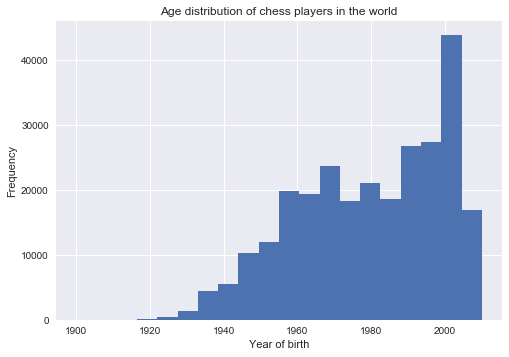

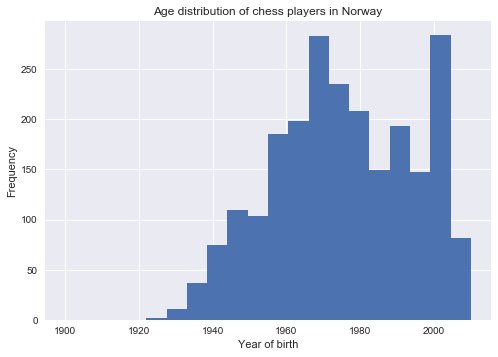

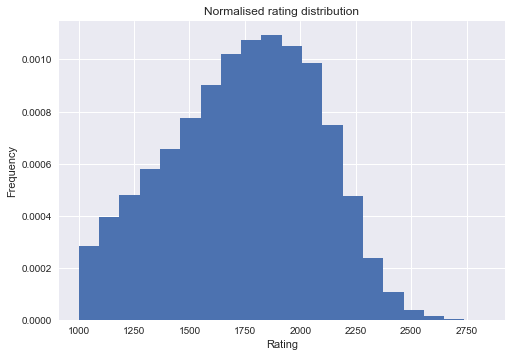

In [6]:
plt.figure()
df['birthday'].plot.hist(bins=20, range=(1900,2010))
plt.title('Age distribution of chess players in the world')
plt.xlabel('Year of birth')
plt.show()

plt.figure()
df['birthday'][df['country']=='Norway'].plot.hist(bins=20,range=(1900,2010))
plt.title('Age distribution of chess players in Norway')
plt.xlabel('Year of birth')
plt.show()

plt.figure()
df.rating.plot.hist(bins=20,normed=True)
plt.title('Normalised rating distribution')
plt.xlabel('Rating')
plt.show()

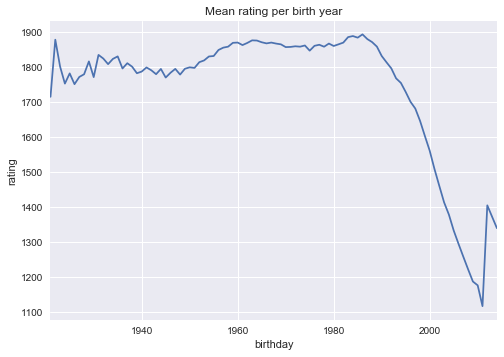

In [7]:
plt.figure()
ratings=df[df.birthday>1920].groupby(['birthday']).agg('mean')['rating'] 
ratings.plot()
plt.title('Mean rating per birth year')
plt.ylabel('rating')
plt.show()

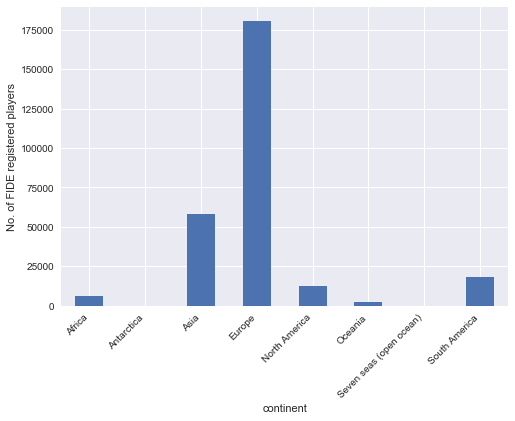

In [8]:
g=df.groupby(['continent'])
plt.figure()
g.count()['fideid'].plot(kind='bar')
plt.ylabel('No. of FIDE registered players')
plt.xticks(rotation=45,ha='right')
plt.show()

## Country statistics and visualisations

Which countries have the most [FIDE titled](https://en.wikipedia.org/wiki/FIDE_titles) players, e.g. Grandmasters (GMs), International masters (IMs), FIDE masters (FMs) and Candidate masters (CMs)? Which countries have most players per capita?

In [9]:
#The below code could probably be cleaned up

group_no_players=df.groupby(['iso_a3']).count()
group_titles=df.groupby(['iso_a3','title']).agg(['count'])['name']

#Prepare for merging:
no_players=group_no_players.reset_index(level=['iso_a3'])
titles=group_titles.reset_index(level=['iso_a3','title'])

gms=titles[titles.title=='GM']
gms=gms.rename(columns={'count': 'count_GM'})
ims=titles[titles.title=='IM']
ims=ims.rename(columns={'count': 'count_IM'})
fms=titles[titles.title=='FM']
fms=fms.rename(columns={'count': 'count_FM'})
cms=titles[titles.title=='CM']
cms=cms.rename(columns={'count': 'count_CM'})

g_sex=df.groupby(['iso_a3','sex']).agg(['count'])['name']
g=g_sex.reset_index(level=['iso_a3','sex'])
F=g[g.sex=='F']
M=g[g.sex=='M']
F=F.rename(columns={'count': 'Female'})
M=M.rename(columns={'count': 'Male'})

df2=reduce(lambda left,right: pd.merge(left,right,how='outer',on='iso_a3'), [no_players,gms,ims,fms,cms,F,M])
df2=df2.rename(columns={'fideid': 'no_players'})

#Clean up (quite unreadable and a bit risky if new stuff is added):
df2.drop(df2.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,21,23,25,27]], axis=1, inplace=True)

#Merge with countries before exporting to Leaflet
df3=pd.merge(df2,countries,how='outer',on='iso_a3')
df3['no_players_mPC']=1e6*(df3['no_players']/df3['pop_est']) #No. of players per million capita

#Export to csv for use with QGIS or Leaflet
df3.fillna(value=0, inplace=True)
df3.to_csv('df3.csv',index=False)

In [10]:
df3.tail()

,iso_a3,no_players,count_GM,count_IM,count_FM,count_CM,Female,Male,country,pop_est,continent,subregion,no_players_mPC
255,WSM,0,0.0,0.0,0.0,0.0,0.0,0.0,Samoa,219998.0,Oceania,Polynesia,0.000000
256,YEM,91,0.0,5.0,5.0,3.0,9.0,74.0,Yemen,23822783.0,Asia,Western Asia,3.819873
257,ZAF,775,1.0,9.0,24.0,40.0,150.0,621.0,South Africa,49052489.0,Africa,Southern Africa,15.799402
258,ZMB,285,1.0,8.0,4.0,14.0,36.0,249.0,Zambia,11862740.0,Africa,Eastern Africa,24.024804
259,ZWE,136,0.0,5.0,2.0,1.0,33.0,103.0,Zimbabwe,12619600.0,Africa,Eastern Africa,10.776887


In [11]:
#Which country has the most number of grandmasters?
gms[gms.count_GM==gms.count_GM.max()]

,iso_a3,title,count_GM
707,RUS,GM,218


In [12]:
#Number of players per million capita
foo=df3.sort_values('no_players_mPC',ascending=False)
foo[['country','no_players_mPC']].head(15)

,country,no_players_mPC
190,Palau,5000.961723
117,Iceland,1806.360737
13,Andorra,691.398055
65,Czech Republic,673.135979
107,Croatia,639.282364
222,Slovenia,634.693662
69,Denmark,622.124130
221,Slovakia,616.505883
217,Republic of Serbia,611.030338
109,Hungary,589.161924


# Create an interactive map using Leaflet.js

Based on [this](http://www.qgistutorials.com/en/docs/performing_table_joins.html) and [this](http://leafletjs.com/examples/choropleth/) tutorial: 

..do the following:

 1. Open *ne_50m_admin_0_countries.shp* as vector layer in QGIS
 2. Open *df3.csv* as a delimited text layer
 3. Join these layers based on the ISO Alpha-3 code (ne_50m_admin_0_countries - Layer Properties - Joins)
 4. Save the resulting layer as a geojson layer, e.g. *countriesData.geojson*
 5. Convert this file to a javascript file *countriesData.js*, i.e.
 
     convert: 

    ```
    {
    "type": "FeatureCollection",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": [
    { "type": "Feature", "properties": { "scalerank": 3, "featurecla": ...
    { "type": "Feature", "properties": { "scalerank": 1, "featurecla": ...
    { "type": "Feature", "properties": { "scalerank": 1, "featurecla": ...
    ...
    ]
    }
    ```
    
    .. into (the line with "crs" can be removed):

  ```
  var countriesData = {"type":"FeatureCollection","features":[
        { "type": "Feature", "properties": { "scalerank": 3, "featurecla": ...
        { "type": "Feature", "properties": { "scalerank": 1, "featurecla": ...
        { "type": "Feature", "properties": { "scalerank": 1, "featurecla": ...
        { "type": "Feature", "properties": { "scalerank": 1, "featurecla": ...
        ...
        ]};
  ```
 6. Open the file [*FIDE_chess_players.html*](https://rawgit.com/oysteinbf/data-analysis/tree/master/chess-players/FIDE_chess_players.html) in a browser (this file links to countriesData.js)
 
 The above procedure can probably be automated without going through QGIS.
 

## Comments

All statistics presented include both active and inactive players. A better representation may be obtained by removing the inactive players from the dataset.